In [3]:

import dicom, lmdb, cv2, re, sys
from dicom.datadict import dictionary_keyword
import dicom.UID
from dicom.dataset import Dataset, FileDataset
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
import pandas as pd
np.random.seed(1234)
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

import datetime, time

In [4]:
SUNNYBROOK_ROOT_PATH = "./Sunnybrook_data2/"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                                  "SCD_ManualContours")
                            
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "SCD_DeidentifiedImages")

#### 1.1 Creating a dictionary of metadata from a set of Dicom files

In [6]:

scans=[]
filelocation = "/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test"

#create a list of all files in given directory
files = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(filelocation )
    for f in fnmatch.filter(files, '*.dcm')]

print files

for file in files:
    dicomds = dicom.read_file(file, stop_before_pixels=True)
    #dicomds = dicom.read_file(file)
    mod_ds = {((dictionary_keyword(data_elem.tag)), (data_elem.tag)): data_elem.value for data_elem in dicomds.values()}
    scans.append(mod_ds)
#     print dicomds.ImageOrientationPatient
#     print dicomds.ImagePositionPatient
#     print dicomds.PixelSpacing

print "Dicom dictionary"
print scans
    
# for fp in files:
#     f = dicom.read_file(fp)
#     #img = f.pixel_array.astype(np.uint8)
#     img = f.pixel_array.astype(np.int)
#     print ("img size : ", img.shape, "max:", img.max(), "min:", img.min());

#     plt.imshow(img, cmap='gray')
#     plt.show()


['/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test/IM-0004-0098_sb.dcm', '/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test/IM-0004-0180_sb.dcm', '/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test/IM-0004-0152_sb.dcm', '/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test/IM-4557-0003_dsb.dcm', '/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test/IM-4557-0002_dsb.dcm', '/Users/skenchar/Documents/DSE/skenchar/capstone/dicom_test/IM-4557-0001_dsb.dcm']
Dicom dictionary
[{('PhotometricInterpretation', (0028, 0004)): 'MONOCHROME2 ', ('ContentTime', (0008, 0033)): '084125.798635 ', ('WindowWidth', (0028, 1051)): '1325', ('HighBit', (0028, 0102)): '\x0f\x00', ('RequestedProcedureID', (0040, 1001)): '4428298 ', ('TriggerTime', (0018, 1060)): '664.556946', ('PatientBirthDate', (0010, 0030)): '', ('SeriesInstanceUID', (0020, 000e)): '1.2.840.113619.2.234.90587033889.4351.1330343039402.6\x00', ('SpecificCharacterSet', (0008, 0005)): 'ISO_IR 100', ('InPlan

In [7]:
print type(dicomds)
dicomds

<class 'dicom.dataset.FileDataset'>


(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'RETRO', 'NORM', 'DIS2D']
(0008, 0013) Instance Creation Time              TM: '143506.468000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.155926562610379287424879000432859632760
(0008, 0030) Study Time                          TM: '141855.484000'
(0008, 0031) Series Time                         TM: '143506'
(0008, 0032) Acquisition Time                    TM: '143456.972500'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'
(0008, 103e) Series Description                  LO: 'sax'
(0008, 1090) Manufacturer's Model Name           LO: 'Aera'
(0008, 1140)  Referenced Image Sequence   3 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: MR Image Storag

### 1.2 Creating a new DICOM file from raw image file

('img size : ', (256, 256), 'max:', 960, 'min:', 0)


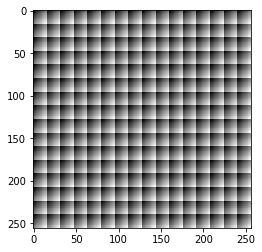

In [149]:
### creating a new DICOM file from raw image file

import dicom, dicom.UID
from dicom.dataset import Dataset, FileDataset
import numpy as np
import datetime, time

def write_dicom(pixel_array,filename):
    """
    INPUTS:
    pixel_array: 2D numpy ndarray.  If pixel_array is larger than 2D, errors.
    filename: string name for the output file.
    """

    ## This code block was taken from the output of a MATLAB secondary
    ## capture.  I do not know what the long dotted UIDs mean, but
    ## this code works.
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = 'Secondary Capture Image Storage'
    file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    file_meta.ImplementationClassUID = '1.3.6.1.4.1.9590.100.1.0.100.4.0'
    ds = FileDataset(filename, {},file_meta = file_meta,preamble="\0"*128)
    ds.Modality = 'WSD'
    ds.ContentDate = str(datetime.date.today()).replace('-','')
    ds.ContentTime = str(time.time()) #milliseconds since the epoch
    ds.StudyInstanceUID =  '1.3.6.1.4.1.9590.100.1.1.124313977412360175234271287472804872093'
    ds.SeriesInstanceUID = '1.3.6.1.4.1.9590.100.1.1.369231118011061003403421859172643143649'
    ds.SOPInstanceUID =    '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    ds.SOPClassUID = 'Secondary Capture Image Storage'
    ds.SecondaryCaptureDeviceManufctur = 'Python 2.7.3'

    ## These are the necessary imaging components of the FileDataset object.
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SmallestImagePixelValue = '\\x00\\x00'
    ds.LargestImagePixelValue = '\\xff\\xff'
    ds.Columns = pixel_array.shape[0]
    ds.Rows = pixel_array.shape[1]
    if pixel_array.dtype != np.uint16:
        pixel_array = pixel_array.astype(np.uint16)
    ds.PixelData = pixel_array.tostring()

    ds.save_as(filename)
    return



#if __name__ == "__main__":
#    pixel_array = np.arange(256*256).reshape(256,256)
#    pixel_array = np.tile(np.arange(256).reshape(16,16),(16,16))
x = np.arange(16).reshape(16,1)
pixel_array = (x + x.T) * 32
pixel_array = np.tile(pixel_array,(16,16))
write_dicom(pixel_array,'pretty.dcm')

myfile = 'pretty.dcm'

dicomds = dicom.read_file(myfile, stop_before_pixels=True)
mod_ds = {((dictionary_keyword(data_elem.tag)), (data_elem.tag)): data_elem.value for data_elem in dicomds.values()}
mod_ds

#dicomds = dicom.read_file(file_o, stop_before_pixels=True)
dicomds = dicom.read_file(myfile)
img = dicomds.pixel_array.astype(np.uint16)
print ("img size : ", img.shape, "max:", img.max(), "min:", img.min());
plt.imshow(img, cmap='gray')
plt.show()

In [165]:
dicomds.ImageOrientationPatient

['0.55555', '-0.4567', '-0.3333', '-0.1234', '0.1111', '0.2222']

### 1.3 Creating a new dicom file with modified pixel_array, orientation, pixel spacing parameters

old img orientation :  ['-0.104592', '0.346381', '-0.932245', '-0.733192', '-0.660188', '-0.163037']
new img orientation :  ['0.55555', '-0.4567', '-0.3333', '-0.1234', '0.1111', '0.2222']
old PixelSpacing :  ['1.367188', '1.367188']
new PixelSpacing :  ['1.55555', '1.5555']
('old Rows, Columns : ', 256, 256)
('old smallest, largest pixels : ', 0, 953)
changing the datatype to uint16
[(('AccessionNumber', (0008, 0050)), ''), (('AcquisitionDate', (0008, 0022)), '20120227'), (('AcquisitionMatrix', (0018, 1310)), '\xe0\x00\x00\x00\x00\x00\xe0\x00'), (('AcquisitionNumber', (0020, 0012)), '1 '), (('AcquisitionTime', (0008, 0032)), '084116.731317 '), (('BitsAllocated', (0028, 0100)), '\x10\x00'), (('BitsStored', (0028, 0101)), '\x10\x00'), (('CardiacNumberOfImages', (0018, 1090)), '20'), (('Columns', (0028, 0011)), '\x00\x01'), (('ContentDate', (0008, 0023)), '20120227'), (('ContentTime', (0008, 0033)), '084125.798635 '), (('ContrastBolusAgent', (0018, 0010)), ''), (('CurrentPatientLocation'

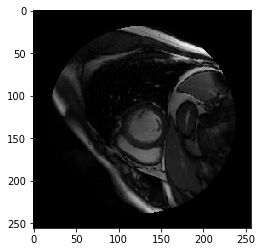

('img size : ', (256, 256), 'max:', 255, 'min:', 0)


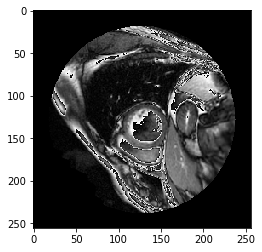

In [11]:

input_file = "dicom_test/IM-0004-0098_sb.dcm"
output_file = "0004-0098_sb_mod2.dcm"


def write_dicom_file(oldfile, newfile, meta_dict):
    ds = dicom.read_file(oldfile)
    if "ImageOrientationPatient" in meta_dict:
        print "old img orientation : ", ds.ImageOrientationPatient
        ds.ImageOrientationPatient = [str(i) for i in meta_dict["ImageOrientationPatient"]]
        print "new img orientation : ", ds.ImageOrientationPatient
    if "PixelSpacing" in meta_dict:
        print "old PixelSpacing : ", ds.PixelSpacing
        ds.PixelSpacing = [str(i) for i in meta_dict["PixelSpacing"]]
        print "new PixelSpacing : ", ds.PixelSpacing
    if "PixelData" in meta_dict:
        print ("old Rows, Columns : ", ds.Rows, ds.Columns)
        print ("old smallest, largest pixels : ", ds.SmallestImagePixelValue, ds.LargestImagePixelValue)
        pixel_array = meta_dict["PixelData"]
        if pixel_array.dtype != np.uint16:
            print ("changing the datatype to uint16")
            pixel_array = pixel_array.astype(np.uint16)
        ds.SmallestImagePixelValue = pixel_array.min()
        ds.LargestImagePixelValue = pixel_array.max()
        ds.Columns = pixel_array.shape[0]
        ds.Rows = pixel_array.shape[1]
        ds.PixelData = pixel_array.tostring()
    ds.save_as(newfile)
    return newfile

     
meta_d = {}

ds2 = dicom.read_file(input_file)
img = ds2.pixel_array.astype(np.int)
pix_arr = img.astype(np.uint8)
new_orientation = [.55555, -.4567, -.3333, -.1234, .1111, .2222]
new_pixel_spacing = [1.55555, 1.5555 ]
#fill the metadata dictionary with appropriate values
meta_d['ImageOrientationPatient'] = new_orientation
meta_d['PixelSpacing'] = new_pixel_spacing
meta_d['PixelData'] = pix_arr

fp = write_dicom_file(input_file, output_file, meta_d)

dicomds = dicom.read_file(fp, stop_before_pixels=True)
#dicomds = dicom.read_file(file_o)
mod_ds = {((dictionary_keyword(data_elem.tag)), (data_elem.tag)): data_elem.value for data_elem in dicomds.values()}
print sorted(mod_ds.items())


img = ds2.pixel_array.astype(np.int)
print ("img size : ", img.shape, "max:", img.max(), "min:", img.min());
plt.imshow(img, cmap='gray')
plt.show()


#now read the dicom file again, along with pixel values
dicomds = dicom.read_file(fp)
img = dicomds.pixel_array.astype(np.int)
print ("img size : ", img.shape, "max:", img.max(), "min:", img.min());
plt.imshow(img, cmap='gray')
plt.show()


In [1]:
#dir(Dataset)

### 1.4 Mapping of contours to images in Sunnybrook training dataset

Mapping ground truth contours to images...
Shuffle data
('./Sunnybrook_data2/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours/SC-HYP-40/contours-manual/IRCCI-expert/IM-0001-0125-icontour-manual.txt', './Sunnybrook_data2/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours/SC-N-40/contours-manual/IRCCI-expert/IM-0001-0209-icontour-manual.txt')
Number of examples: 260
('Contour 0 :', 'SC-HYP-40', 125)
('Contour -1 :', 'SC-N-40', 209)
Done mapping ground truth contours to images

Building LMDB for train...
Processing 234 images and labels...
<Contour for case SC-HYP-40, image 185>
Img : (256, 256) 0 1063
Label : (256, 256) 0 1


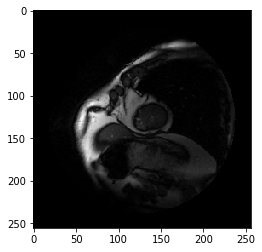

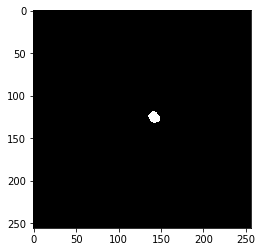

<Contour for case SC-HYP-38, image 106>
Img : (256, 256) 0 705
Label : (256, 256) 0 1


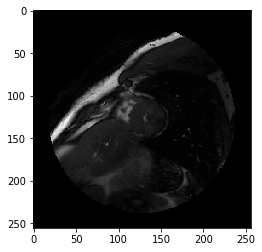

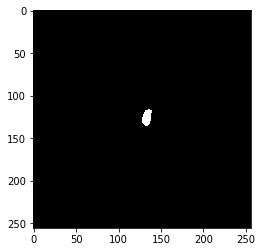

<Contour for case SC-HF-I-2, image 147>
Img : (256, 256) 0 891
Label : (256, 256) 0 1


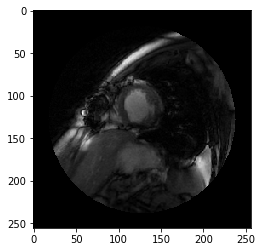

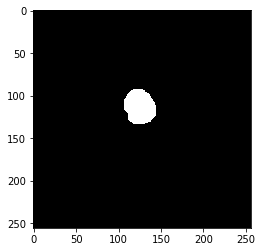

<Contour for case SC-HYP-3, image 108>
Img : (256, 256) 0 878
Label : (256, 256) 0 1


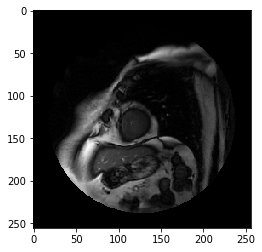

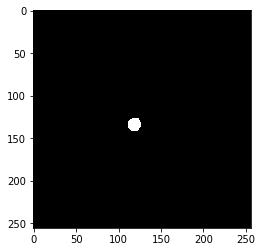

<Contour for case SC-HF-NI-34, image 47>
Img : (256, 256) 0 957
Label : (256, 256) 0 1


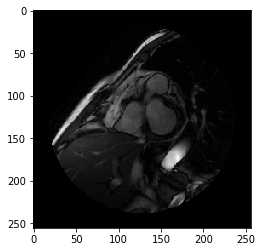

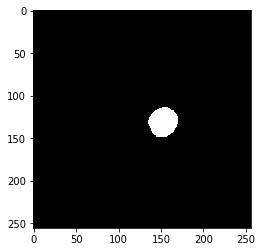

<Contour for case SC-HYP-38, image 186>
Img : (256, 256) 0 791
Label : (256, 256) 0 1


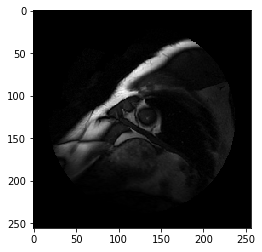

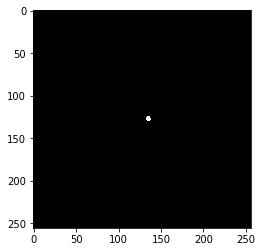

<Contour for case SC-HYP-38, image 158>
Img : (256, 256) 0 729
Label : (256, 256) 0 1


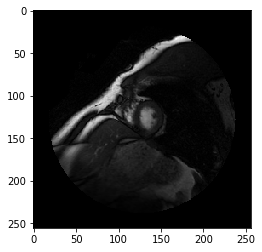

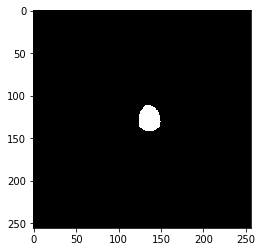

<Contour for case SC-HF-NI-34, image 219>
Img : (256, 256) 0 1039
Label : (256, 256) 0 1


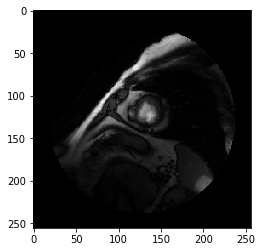

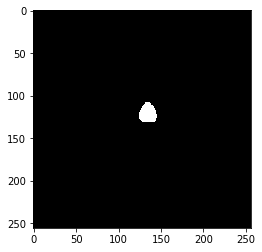

<Contour for case SC-HF-I-1, image 119>
Img : (256, 256) 0 738
Label : (256, 256) 0 1


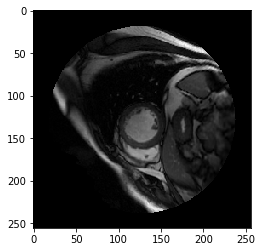

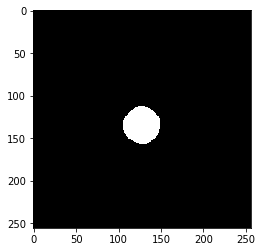

<Contour for case SC-N-2, image 120>
Img : (256, 256) 0 439
Label : (256, 256) 0 1


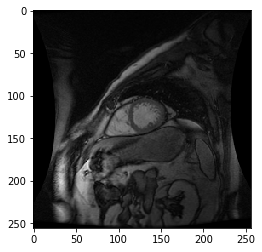

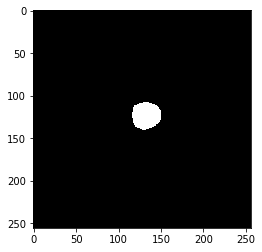

<Contour for case SC-HF-NI-3, image 140>
Img : (256, 256) 0 1033
Label : (256, 256) 0 1


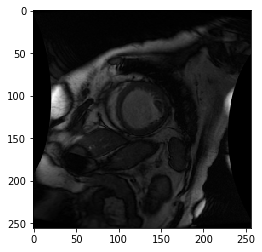

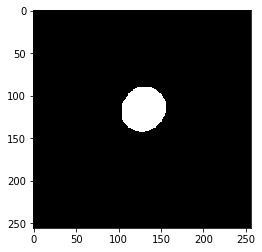

<Contour for case SC-HF-NI-36, image 229>
Img : (256, 256) 0 1598
Label : (256, 256) 0 1


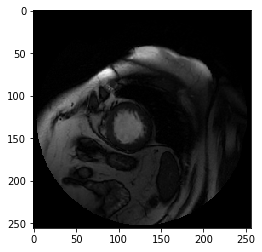

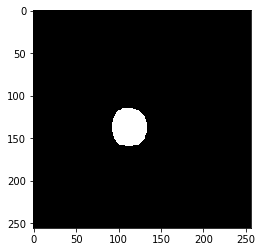


Building LMDB for val...
Processing 26 images and labels...
<Contour for case SC-HYP-40, image 125>
Img : (256, 256) 0 964
Label : (256, 256) 0 1


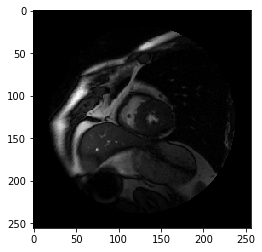

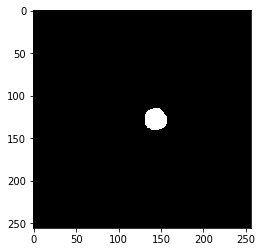

<Contour for case SC-HF-I-1, image 188>
Img : (256, 256) 0 783
Label : (256, 256) 0 1


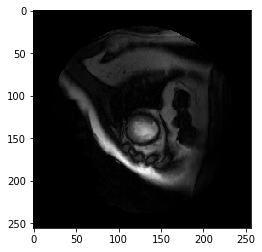

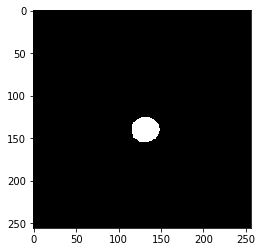

In [12]:
SAX_SERIES = {
    # challenge training
    "SC-HF-I-1": "0004",
    "SC-HF-I-2": "0106",
    "SC-HF-I-4": "0116",
    "SC-HF-I-40": "0134",
    "SC-HF-NI-3": "0379",
    "SC-HF-NI-4": "0501",
    "SC-HF-NI-34": "0446",
    "SC-HF-NI-36": "0474",
    "SC-HYP-1": "0550",
    "SC-HYP-3": "0650",
    "SC-HYP-38": "0734",
    "SC-HYP-40": "0755",
    "SC-N-2": "0898",
    "SC-N-3": "0915",
    "SC-N-40": "0944",
}

SUNNYBROOK_ROOT_PATH = "./Sunnybrook_data2/"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart3",
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_training")

def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return "<Contour for case %s, image %d>" % (self.case, self.img_no)
    
    __repr__ = __str__

def load_contour2(contour, img_path):
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label

def load_contour(contour, img_path):
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    #img = f.pixel_array.astype(np.uint8)


    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    #cv2.fillPoly(label, [ctrs], [255,104,  255])
    #cv2.fillPoly(label, [ctrs], 255)
    cv2.fillPoly(label, [ctrs], 1)
    return img, label

#     img2 = img.copy() + label
#     return img2, label

# def overlay_contours():
#     # Draw contours on top of image with a nice yellow tint
#     overlay = np.zeros(self.sheet.orig_img.shape, np.uint8)
#     contours = map(lambda x: x.contour, self.get_shreds())

#     # Filled yellow poly.
#     cv2.fillPoly(overlay, contours, [104, 255, 255])
#     img = self.sheet.orig_img.copy() + overlay

#     # Add green contour.
#     cv2.drawContours(img, contours, -1, [0, 180, 0], 2)
#     return img
    
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print (contours[0], contours[-1])
    print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    print ("Contour 0 :", extracted[0].case, extracted[0].img_no)
    print ("Contour -1 :", extracted[-1].case, extracted[-1].img_no)


    return extracted

def export_all_contours(contours, img_path, lmdb_img_name, lmdb_lab):

    counter_img = 0
    counter_label = 0
    batchsz = 100
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in xrange(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        for idx,ctr in enumerate(batch):
            try:
                img, label = load_contour(ctr, img_path)
                imgs.append(img)
                labels.append(label)
                if idx % 20 == 0:
                    print ctr
                    print "Img :", img.shape, img.min(), img.max()
                    print "Label :", label.shape, label.min(), label.max()
                    plt.imshow(img,cmap='gray')
                    plt.show()
                    plt.imshow(label, cmap='gray')
                    plt.show()
            except IOError:
                continue


if __name__== "__main__":
    SPLIT_RATIO = 0.1
    print("Mapping ground truth contours to images...")
    ctrs = get_all_contours(TRAIN_CONTOUR_PATH)
    val_ctrs = ctrs[0:int(SPLIT_RATIO*len(ctrs))]
    train_ctrs = ctrs[int(SPLIT_RATIO*len(ctrs)):]
    print("Done mapping ground truth contours to images")
    print("\nBuilding LMDB for train...")
    export_all_contours(train_ctrs, TRAIN_IMG_PATH, "train_images_lmdb", "train_labels_lmdb")
    print("\nBuilding LMDB for val...")
    export_all_contours(val_ctrs, TRAIN_IMG_PATH, "val_images_lmdb", "val_labels_lmdb")